<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/Ryan/initial_model_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import keras

print(tf.__version__)

2.12.0


## Preparing the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filenames = os.listdir("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train")

In [4]:
train_imgs = np.empty((0,2048, 2500))
FileIDs = []

#getting the first 100 images
for i in range(100):
  #Making sure the images are the same pixel size
  img = plt.imread(f"/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train/{filenames[i]}")
  img_shape = img.shape

  if img_shape == (2048, 2500):
    #Save filename for later
    FileIDs.append(filenames[i])

    #add extra dimension so we can concatenate
    img = np.expand_dims(img,(0))

    #adding to train_imgs array
    train_imgs = np.concatenate((train_imgs, img), axis = 0)

train_imgs.shape

(48, 2048, 2500)

In [5]:
train_tensor = np.reshape(train_imgs, (48, 2048, 2500, 1))

In [6]:
# makes img 2x smaller
max_pooling = tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2, padding = "valid")
pooled_array = max_pooling(train_tensor)

In [7]:
#extracting just the CVC labels
train_data = pd.read_csv("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train.csv")
CVC_train = train_data[["StudyInstanceUID","CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]]
CVC_train.set_index('StudyInstanceUID', inplace=True)
CVC_train.head()

,CVC - Abnormal,CVC - Borderline,CVC - Normal
StudyInstanceUID,,,
1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561,0,0,0
1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729,0,0,1
1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577,0,1,0
1.2.826.0.1.3680043.8.498.68286643202323212801283518367144358744,1,0,0
1.2.826.0.1.3680043.8.498.10050203009225938259119000528814762175,0,0,1


In [8]:
#cleaning up the labels
UID = []
for i in range(len(FileIDs)):
  UID.append(FileIDs[i].replace(".jpg",""))

UID[0:10]

['1.2.826.0.1.3680043.8.498.96315500926641444675409331764690933307',
 '1.2.826.0.1.3680043.8.498.96450515721778915344219421534269786290',
 '1.2.826.0.1.3680043.8.498.96359554498564333142663951388648557789',
 '1.2.826.0.1.3680043.8.498.96447675290915183668080373345495953473',
 '1.2.826.0.1.3680043.8.498.96279880013483713441521686300695558821',
 '1.2.826.0.1.3680043.8.498.96349754766067875463134738379718157835',
 '1.2.826.0.1.3680043.8.498.96406955712119661656412685705445497931',
 '1.2.826.0.1.3680043.8.498.96346896468102014556173811602388995798',
 '1.2.826.0.1.3680043.8.498.96332366015730959061321671670587275158',
 '1.2.826.0.1.3680043.8.498.96365165965335417502443200533971674013']

In [9]:
train_labels = np.empty((0,3))
data = []
for ID in UID:
    data.append(CVC_train.loc[ID])

train_labels_df = pd.DataFrame(data)

train_labels_df = train_labels_df.reindex(UID)

train_labels = train_labels_df.values

## Making and training the model

In [10]:
if np.all(train_labels[1] == [0,0,1]):
  print('hello')

hello


In [11]:
def get_allignment(labels):
  result = ""
  if np.any(labels == [2,2,1]):
    result += "Normal"

  elif np.any(labels == [2,1,2]):
    result += "Borderline"

  elif np.any(labels == [1,2,2]):
    result += "Abnormal"

  return result

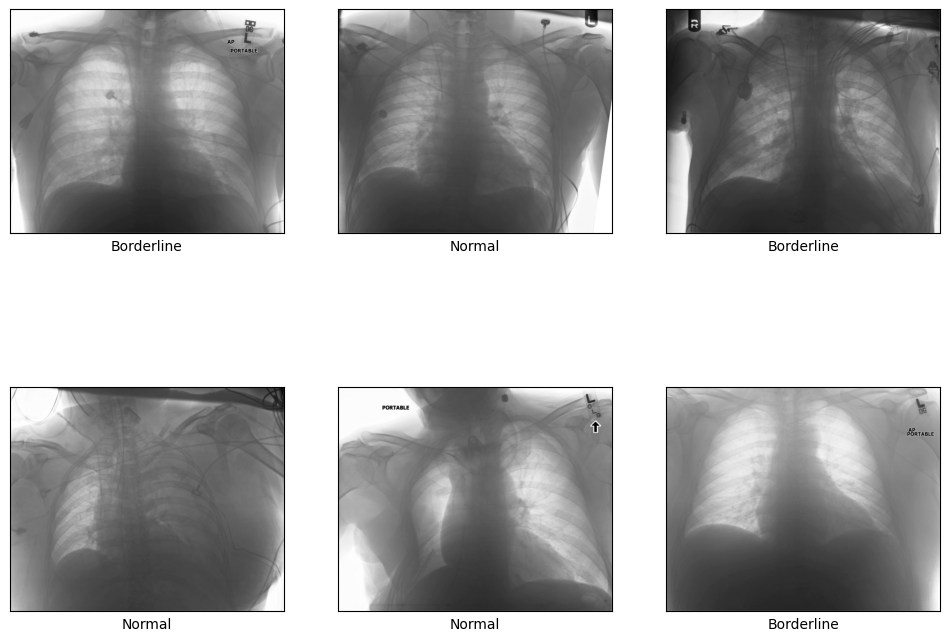

In [12]:
#displaying 6 of the images in the pooled_imgs array
plt.figure(figsize=(12,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(pooled_array[i], cmap=plt.cm.binary)
  plt.xlabel(get_allignment(train_labels[i]))
plt.show()

In [13]:
pooled_array[0].shape

TensorShape([1024, 1250, 1])

In [14]:
lr = 0.000005
epochs=100
img_size = (1024, 1250)

In [15]:
#initiating the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=img_size),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3)
    ])

In [16]:
#compling the model
optim = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optim,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)

In [17]:
#fitting the model
history = model.fit(pooled_array, train_labels, epochs=epochs)

Epoch 1/100
2/2 [==============================] - 6s 2s/step - loss: 397.0175 - accuracy: 0.3958
Epoch 2/100
2/2 [==============================] - 3s 1s/step - loss: 855.8772 - accuracy: 0.5833
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 537.0210 - accuracy: 0.5417
Epoch 4/100
2/2 [==============================] - 4s 2s/step - loss: 174.6266 - accuracy: 0.5833
Epoch 5/100
2/2 [==============================] - 3s 1s/step - loss: 122.2074 - accuracy: 0.3542
Epoch 6/100
2/2 [==============================] - 4s 1s/step - loss: 93.0095 - accuracy: 0.5833
Epoch 7/100
2/2 [==============================] - 2s 963ms/step - loss: 253.6956 - accuracy: 0.1667
Epoch 8/100
2/2 [==============================] - 3s 2s/step - loss: 135.1093 - accuracy: 0.5833
Epoch 9/100
2/2 [==============================] - 3s 1s/step - loss: 189.7440 - accuracy: 0.5833
Epoch 10/100
2/2 [==============================] - 3s 1s/step - loss: 126.4880 - accuracy: 0.5208
Epoch 11/100
2/2 

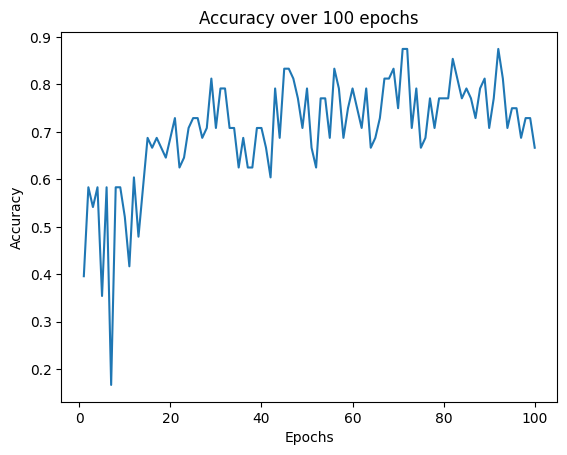

In [18]:
plt.plot(range(1,epochs+1), history.history["accuracy"])
plt.title(f"Accuracy over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

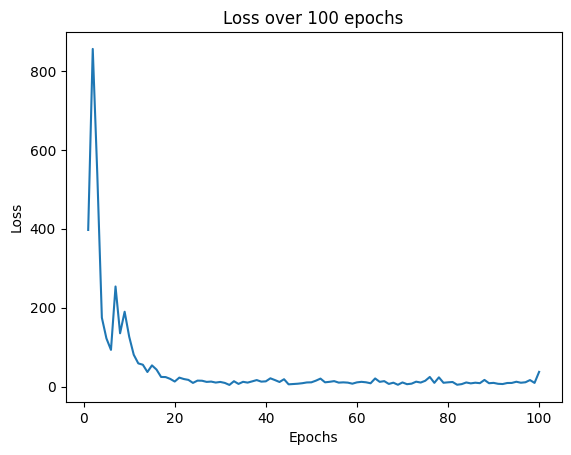

In [19]:
plt.plot(range(1,epochs+1), history.history["loss"])
plt.title(f"Loss over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss");